In [1]:
from csromer.simulation import FaradayThinSource,FaradayThickSource
from csromer.reconstruction import Parameter
import numpy as np
from IPython.display import clear_output
from csromer.io import Reader, Writer
from csromer.base import Dataset
from csromer.transformers import DFT1D, NUFFT1D
import matplotlib.pyplot as plt
from csromer.objectivefunction import OFunction
from csromer.utils import real_to_complex, complex_to_real
from csromer.objectivefunction import TSV, TV, L1, Chi2
from csromer.optimization import FISTA, ADMM, SDMM, GradientBasedMethod
from csromer.utils import Gaussian
from csromer.dictionaries.discrete import DiscreteWavelet
from csromer.dictionaries.undecimated import UndecimatedWavelet
from csromer.transformers import Gridding, MeanFlagger, HampelFlagger
from csromer.faraday_sky import FaradaySky
from scipy.constants import c
from pynufft import NUFFT
from scipy import signal as sci_signal
import itertools
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as un
from astropy.stats import sigma_clipped_stats
import pandas as pd

In [2]:
# Read cubes
Q_name = "/home/miguel/Documents/datasets/A1314_JVLA/cubes/A1314_Q_corrected.fits"
U_name = "/home/miguel/Documents/datasets/A1314_JVLA/cubes/A1314_U_corrected.fits"

hdul_q = fits.open(Q_name, memmap=True)
hdul_u = fits.open(U_name, memmap=True)

In [3]:
# Read spectral index
spc_idx_name = "/home/miguel/Documents/datasets/A1314_JVLA/cubes/alpha_0.fits"
hdul_alpha = fits.open(spc_idx_name, memmap=True)

In [4]:
# Read frequencies
freq_name = "/home/miguel/Documents/datasets/A1314_JVLA/cubes/freqs.npy"
freqs = np.load(freq_name)

In [5]:
# Get LOS
#coord = SkyCoord("11:33:59.1755+49:03:44.108", unit=(un.hourangle, un.deg), frame="fk5")
#coord = SkyCoord(ra=173.705*un.deg, dec=49.077*un.deg, frame="fk5")
#coord = SkyCoord(ra=173.803*un.deg, dec=48.966*un.deg, frame="fk5")
coord = SkyCoord(ra=173.571*un.deg, dec=49.151*un.deg, frame="fk5")

In [6]:
# Get WCS
wcs = WCS(hdul_q[0].header)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [7]:
# Get pixel
x,y = coord.to_pixel(wcs, origin=0)
x = int(x)
y = int(y)

In [8]:
q_data = np.flipud(hdul_q[0].data)
u_data = np.flipud(hdul_u[0].data)

In [9]:
# Get sigma
mean_q, median_q, std_q = sigma_clipped_stats(q_data[:, 0:300, 0:300], sigma=3, axis=(1,2))
mean_u, median_u, std_u = sigma_clipped_stats(u_data[:, 0:300, 0:300], sigma=3, axis=(1,2))
#std_q = np.nanstd(q_data[:, 0:100, 0:100], axis=(1, 2))
#std_u = np.nanstd(u_data[:, 0:100, 0:100], axis=(1, 2))

In [10]:
sigma_qu = 0.5*(std_q + std_u)

In [11]:
data = q_data[:,y,x] + 1j * u_data[:,y,x]
alpha = hdul_alpha[0].data[y,x]

In [12]:
measurements = Dataset(nu=freqs, data=data, sigma=sigma_qu, spectral_idx=alpha)

In [13]:
# Get galactic RM contribution
f_sky = FaradaySky(filename="./../faradaysky/faraday2020v2.hdf5")
gal_mean, gal_std = f_sky.galactic_rm(coord.ra, coord.dec, frame="fk5")

In [14]:
measurements.subtract_galacticrm(gal_mean.value)

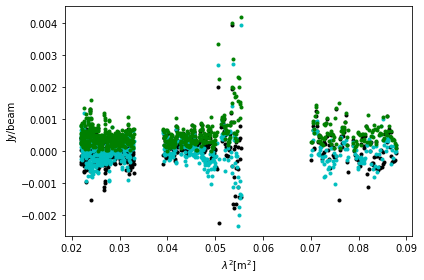

In [15]:
plt.plot(measurements.lambda2, measurements.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
#plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

Text(0, 0.5, '1/(Jy/beam)$^2$')

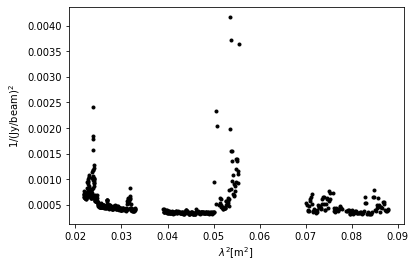

In [16]:
plt.plot(measurements.lambda2, measurements.sigma, 'k.', label=r"$\sigma$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'1/(Jy/beam)$^2$')

In [17]:
## Flagging dataset ##
normal_flagger = MeanFlagger(data=measurements, nsigma=5.0, delete_channels=True)
idxs, outliers_idxs = normal_flagger.run()

hampel_flagger = HampelFlagger(data=measurements, nsigma=5.0, delete_channels=True)
idxs, outliers_idxs = hampel_flagger.run()

Flagging 24.05% of the data
Flagging 0.00% of the data


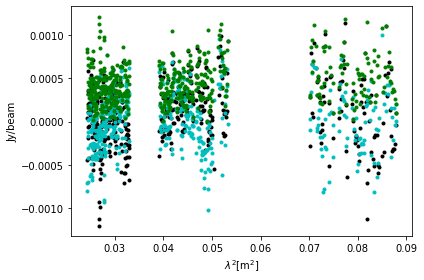

In [18]:
plt.plot(measurements.lambda2, measurements.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
#plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

Text(0, 0.5, 'Jy/beam')

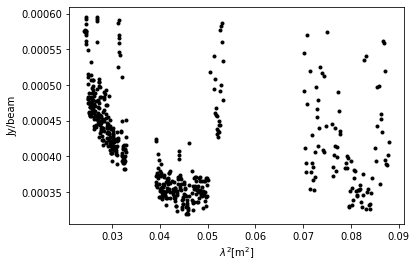

In [19]:
plt.plot(measurements.lambda2, measurements.sigma, 'k.', label=r"$\sigma$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')

In [20]:
parameter = Parameter()

In [21]:
parameter.calculate_cellsize(dataset=measurements, oversampling=8)

FWHM of the main peak of the RMTF: 54.380 rad/m^2
Maximum recovered width structure: 129.664 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 14057.225


In [22]:
nufft = NUFFT1D(dataset=measurements, parameter=parameter, solve=True)

In [23]:
dft = DFT1D(dataset=measurements, parameter=parameter)

In [24]:
F_dirty = dft.backward(measurements.data)

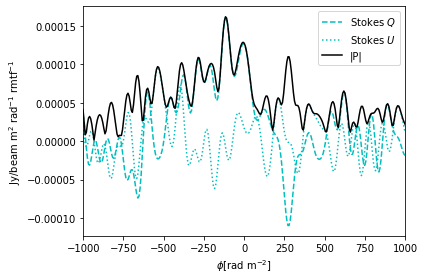

In [25]:
plt.plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_dirty), 'k-', label=r"|P|")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000,1000])
plt.tight_layout()
plt.savefig('fdirty.png', dpi=100, bbox_inches='tight')

In [26]:
noise = 0.5*0.5 * (np.std(F_dirty.real[np.abs(parameter.phi)>parameter.max_faraday_depth/1.5]) + np.std(F_dirty.imag[np.abs(parameter.phi)>parameter.max_faraday_depth/1.5]))
#noise = 1/np.sqrt(np.sum(measurements.w))
noise

6.018684871378355e-06

In [27]:
parameter.data = F_dirty

In [28]:
parameter.complex_data_to_real()

In [29]:
lambda_l1 = np.sqrt(2 * len(measurements.data) + np.sqrt(4 * len(measurements.data))) * noise
#lambda_l1 = np.sqrt(len(measurements.data)) * noise_F
#lambda_l1 /= 10
#lambda_l1=0.5
lambda_tsv = 0.0
chi2 = Chi2(dft_obj=nufft)
l1 = L1(reg=lambda_l1)
tsv = TSV(reg=lambda_tsv)
# F_func = [chi2(P, dft, W), L1(lambda_l1)]
F_func = [chi2, l1, tsv]
f_func = [chi2]
g_func = [l1, tsv]

F_obj = OFunction(F_func)
f_obj = OFunction(f_func)
g_obj = OFunction(g_func)

In [30]:
opt = FISTA(guess_param=parameter, F_obj=F_obj, fx=chi2, gx=g_obj, noise=noise, verbose=True)
#opt = FISTA(i_guess=F_real, F_obj=F_obj, fx=chi2, gx=g_obj, maxiter=1000, noise=1e-5, verbose=True)
obj, X = opt.run()

Iterations set to 32
Iteration:  0  objective function value: 363.80127
Exit due to tolerance:  0.0  <  1e-15
Iterations:  1


In [31]:
X.real_data_to_complex()

(-1000.0, 1000.0)

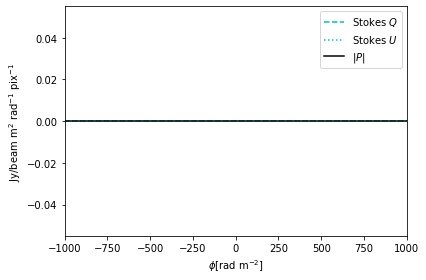

In [32]:
plt.plot(parameter.phi, X.data.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, X.data.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(X.data), 'k-', label=r"$|P|$")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim([-1000,1000])

(-1000.0, 1000.0)

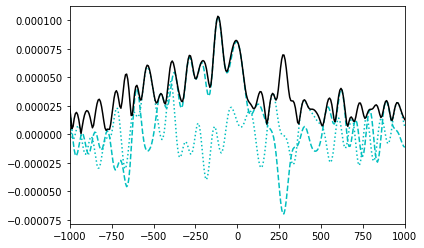

In [33]:
F_residual = nufft.backward(measurements.residual)
plt.plot(parameter.phi, F_residual.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_residual.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_residual), 'k-', label=r"$|P|$")
plt.xlim([-1000,1000])

In [34]:
conv_model = X.convolve(normalized=True) + F_residual

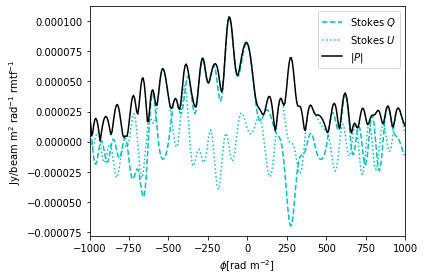

In [35]:
plt.plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(conv_model), 'k-', label=r"$|P|$")
plt.xlim([-1000,1000])
#plt.axhline (y = noise_weights, color = 'b')
#plt.axhline (y = -noise_weights, color = 'b')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()

In [36]:
phi_idx = np.argmax(np.abs(conv_model))
parameter.phi[phi_idx]

-115.78140867691897

In [37]:
np.max(np.abs(conv_model))

0.00010365291359163343